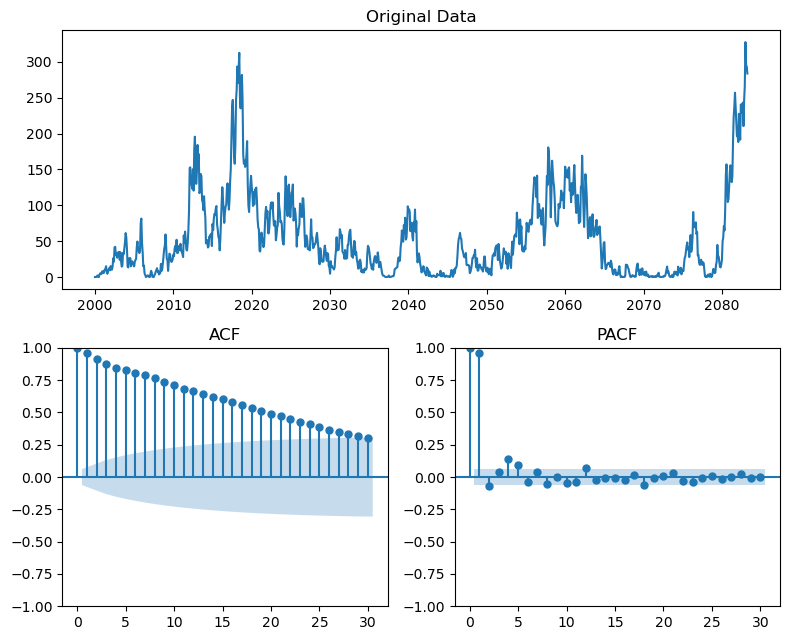

In [163]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as st
import statsmodels.api as sm
import numpy as np

test_with_artificial = True

def artificial_arima(p=np.array([]), d=0, q = np.array([]), f=lambda x:x, n = 100, m = 0):
    # generate synthetic data in order to validate our method for real data
    a  = np.random.normal(0,1,n)
    W = np.zeros(n)
    for t in range(n):   
        if t < len(p) or t < len(q):
            W[t] = 0 # maybe this can be done cleaner but whatever
        else:
            W[t] = - W[t-len(p):t] @ p[::-1] + a[t] + a[t-len(q):t] @ q[::-1] 
    
    for d_c in range(d):
        W = np.cumsum(W) 
        
    W += m    
        
    return f(W)
    
    


if test_with_artificial:
    n = 1000
    points = artificial_arima(
        p = np.array([0,0.1,0.2]),
        q = np.array([0,0.1]),
        d = 1,
        f = lambda x:x**2,
        n = n,
        m = 0.01
    )
    dates = pd.date_range(start='2000-01-01', periods=n, freq='MS')
    
    # Create DataFrame with datetime index
    time_series_df = pd.DataFrame({'points': points}, index=dates)
else:
    # Load the CSV file
    time_series_df = pd.read_csv('EUR_USD_monthly.csv', 
                            parse_dates=[0],  # Parse first column as dates
                            index_col=0)  # Set first column as index
    time_series_df['points'] = time_series_df.iloc[:, 0].replace(',', '', regex=True).astype(float)

time_series_df = time_series_df.asfreq('MS')
    

    
def plot_series(series, series_title, alpha = 0.05):
    """
    Plots the time series, ACF, and PACF with custom titles in a 2-column layout.

    Parameters:
    - series: The time series data to plot.
    - series_title: Title for the time series plot.
    """
    # Create a figure with custom layout using gridspec
    fig = plt.figure(figsize=(8, 6.5))
    gs = fig.add_gridspec(2, 2)   # 1 row, 2 columns

    # First column: Time Series plot (span both rows)
    ax0 = fig.add_subplot(gs[0, :])
    ax0.plot(series)
    ax0.set_title(series_title)

    # Second column: ACF and PACF plots
    # ACF plot
    ax1 = fig.add_subplot(gs[1, 0])
    plot_acf(series, ax=ax1, alpha=alpha)
    ax1.set_title("ACF")

    # PACF plot
    ax2 = fig.add_subplot(gs[1, 1])  # Reuse the same axis for PACF
    plot_pacf(series, ax=ax2, alpha=alpha)
    ax2.set_title("PACF")

    # Show the plots
    plt.tight_layout()
    plt.show()
    
    
plot_series(time_series_df['points'], "Original Data")


Use a full automatic test to which we can compare our results to

In [164]:
if False:
    import pmdarima as pm
    
    # Automatically fit the best ARIMA/SARIMA model
    model = pm.auto_arima(
        time_series_df,
        seasonal=False,      # Enable seasonal differencing if necessary
        stepwise=True,      # Use stepwise algorithm for faster computation
        trace=True,         # Show the fitting process details
        max_p=7,              # Set maximum p value to control AR component
        max_q=7,              # Set maximum q value to control MA component
        max_d=1,              # Set maximum differencing order
        max_P=1,              # Set maximum seasonal AR order
        max_Q=1,              # Set maximum seasonal MA order
        max_D=1,
        max_order = 10
    )
    
    
    # Summary of the best model found
    print(model.summary())
    
    # Predict future values (e.g., next 12 periods)
    forecast = model.predict(n_periods=12)


Test stationarity, Augmented Dickey-Fuller unit root test.

In [165]:
#Check stationarity
# alternative hypothesis is stationarity 
st.adfuller(time_series_df['points'])


(-1.8223363108084552,
 0.36943006886313157,
 5,
 994,
 {'1%': -3.43694584277544,
  '5%': -2.8644520725172873,
  '10%': -2.5683205291305176},
 8026.97227719191)

p value > 0.05 => we can not conclude stationarity

apply box cox transformation, and use scipy to estimate optimal box cox parameter lambda (todo explain what method scipy uses)

used lambda:  0.5


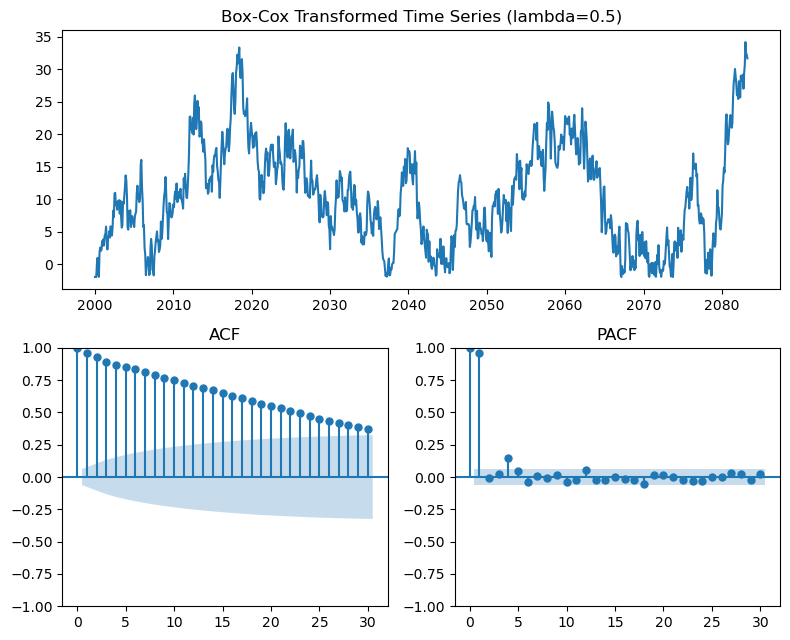

In [166]:
from scipy import stats
use_trafo = True
if use_trafo:
    # Apply Box-Cox transformation and estimate lambda
    lmbda = .5
    if lmbda is None:
        transformed_prices, lmbda = stats.boxcox(time_series_df["points"])
    else:
        transformed_prices = stats.boxcox(time_series_df["points"], lmbda =lmbda)
    
    # Store the transformed values back into the DataFrame
    time_series_df['T_points'] = transformed_prices
    print("used lambda: ", lmbda)
else:
    time_series_df['T_points'] = time_series_df['points']
plot_series(time_series_df['T_points'], f"Box-Cox Transformed Time Series (lambda={lmbda})")
    


Differentiate and see when stationarity tests become positive

In [167]:
alpha = 0.005

        

# Assuming 'time_series_df' is your DataFrame and 'Prices' is the column
current_series = time_series_df['T_points'] 
differencing_count = 0

# Function to apply ADF test and get p-value
def get_adf_p_value(series):
    adf_result = st.adfuller(series.dropna())
    return adf_result[1]  # Return p-value from ADF test

# Keep iterating until the series is stationary or we reach the max differencing
while get_adf_p_value(current_series) >= alpha:
    differencing_count += 1
    # Apply first-order differencing
    current_series = current_series.diff() # drop NaNs that come to existance by doing diff operation

    # Add the differenced series to the DataFrame
    time_series_df['diff_points'] = current_series.copy()
    # Print progress with the p-value after differencing
    print(f"After {differencing_count} differencing(s), the ADF p-value is: {get_adf_p_value(current_series)}")


# Check if series is stationary after differencing
if get_adf_p_value(current_series) < alpha:
    print(f"Series is stationary after {differencing_count} differencings.")
    print("")
else:
    print("Max differencings reached without achieving stationarity.")





After 1 differencing(s), the ADF p-value is: 0.0
Series is stationary after 1 differencings.



Plot the new time series and acf and pcf

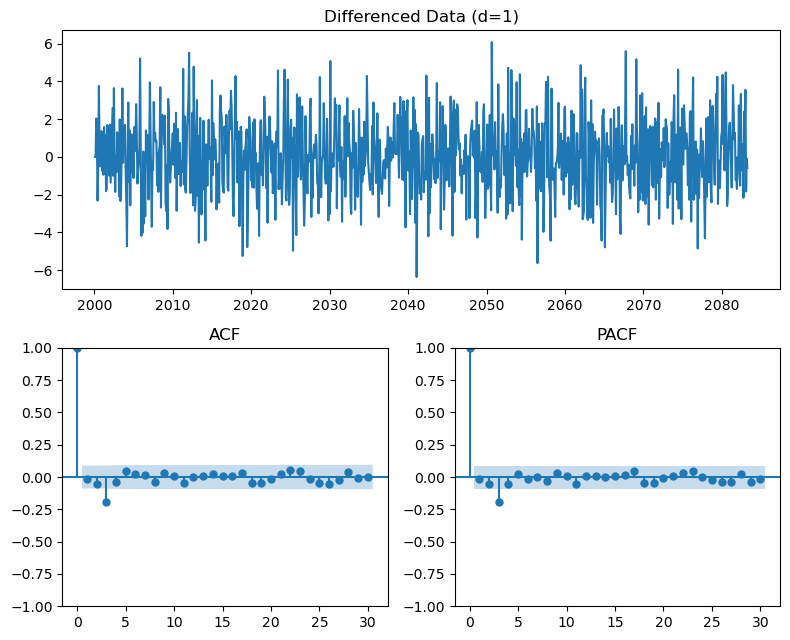

In [168]:
data = time_series_df['diff_points'].dropna() #dropnans from differentiating

plot_series(data, f"Differenced Data (d={differencing_count})", alpha = 0.005)


Print out all lags that are sginificantly non zero

In [173]:
data = time_series_df['diff_points'].dropna()

def print_significant_lags(data, alpha=0.005, nlags=40):
    """
    Calculate and print all significantly non-zero lags using ACF.
    
    Parameters:
    -----------
    data : array-like
        The time series data
    alpha : float, default=0.05
        Significance level for the confidence intervals
    nlags : int, default=40
        Number of lags to calculate
    
    Returns:
    --------
    tuple
        - List of significant lag indices
        - ACF values for significant lags
        - Confidence intervals
    """
    # Calculate ACF with confidence intervals
    acf_values, acf_confint = st.acf(data, alpha=alpha, fft=True, nlags=nlags, adjusted=True)
    pacf_values, pacf_confint = st.pacf(data, alpha=alpha, nlags=nlags)
    
    # The confidence intervals come as [lower, upper] for each lag
    # If 0 is not in [lower, upper], the lag is significant
    acf_significant_lags = []
    acf_significant_values = []
    
    print(f"\nSignificant lags at {alpha*100}% significance level:")
    print("----------------------------------------")
    print("Lag | ACF Value | Confidence Interval")
    print("----------------------------------------")
    
    for lag in range(len(acf_values)):
        lower_ci = acf_confint[lag][0]
        upper_ci = acf_confint[lag][1]
        
        # Check if 0 is outside the confidence interval
        if (lower_ci > 0) or (upper_ci < 0):
            acf_significant_lags.append(lag)
            acf_significant_values.append(acf_values[lag])
            print(f"{lag:3d} | {acf_values[lag]:9.3f} | [{lower_ci:6.3f}, {upper_ci:6.3f}]")
    
    
    # The confidence intervals come as [lower, upper] for each lag
    # If 0 is not in [lower, upper], the lag is significant
    pacf_significant_lags = []
    pacf_significant_values = []
    
    print(f"\nSignificant lags at {alpha*100}% significance level:")
    print("----------------------------------------")
    print("Lag | PACF Value | Confidence Interval")
    print("----------------------------------------")
    
    for lag in range(len(pacf_values)):
        lower_ci = pacf_confint[lag][0]
        upper_ci = pacf_confint[lag][1]
        
        # Check if 0 is outside the confidence interval
        if (lower_ci > 0) or (upper_ci < 0):
            pacf_significant_lags.append(lag)
            pacf_significant_values.append(acf_values[lag])
            print(f"{lag:3d} | {pacf_values[lag]:10.3f} | [{lower_ci:6.3f}, {upper_ci:6.3f}]")
    
    
    if not acf_significant_lags and not pacf_significant_lags:
        print("No significant lags found.")
   
    return (acf_significant_lags, acf_significant_values, acf_confint), (pacf_significant_lags, pacf_significant_values, pacf_confint)
sig = print_significant_lags(data)


Significant lags at 0.5% significance level:
----------------------------------------
Lag | ACF Value | Confidence Interval
----------------------------------------
  0 |     1.000 | [ 1.000,  1.000]
  3 |    -0.194 | [-0.283, -0.105]

Significant lags at 0.5% significance level:
----------------------------------------
Lag | PACF Value | Confidence Interval
----------------------------------------
  0 |      1.000 | [ 1.000,  1.000]
  3 |     -0.196 | [-0.285, -0.107]


From the significant acf and pacf lags and the acf and pacf graphs we can
propose these models: (TODO adjat models to real life data and add explanations)
ARIMA(5,1,0)
ARIMA(0,1,5)
ARIMA(5,1,5)




## Estimate Parameters

In [175]:
from statsmodels.tsa.arima.model import ARIMA

data = time_series_df['diff_points'].dropna()

suggested_models = np.array([
    [0,1,0],
    [2,1,0],
    [0,1,2],
    [2,1,2]
])
results = []
for p, d, q in suggested_models:
        model = ARIMA(data, order=(p, d, q))
        fitted = model.fit()
        
        results.append({
            'order': f"ARIMA({p},{d},{q})",
            'aic': fitted.aic,
            'bic': fitted.bic,
            'p': p,
            'd': d,
            'q': q
        })
        
        print(f"\nARIMA({p},{d},{q}):")
        print(f"AIC: {fitted.aic:.2f}")
        print(f"BIC: {fitted.bic:.2f}")
            
        


ARIMA(0,1,0):
AIC: 4883.59
BIC: 4888.50

ARIMA(2,1,0):
AIC: 4568.47
BIC: 4583.19

ARIMA(0,1,2):
AIC: 4189.95
BIC: 4204.67


/home/daniels/.conda/envs/adlr/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



ARIMA(2,1,2):
AIC: 4193.29
BIC: 4217.82
